In [ ]:
import kagglehub
import pandas as pd
import os
import cv2 as cv

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
import numpy as np

from PIL import Image

In [ ]:
path = kagglehub.dataset_download("sunnykusawa/ecommerce-products-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sunnykusawa/ecommerce-products-image-dataset/versions/1


In [ ]:
categories = ["jeans", "sofa", "tshirt", "tv"]

In [ ]:
categories = ["jeans", "sofa", "tshirt", "tv"]

remove_numbers = {str(num) for num in [100, 103, 104, 108, 116, 117, 149, 161, 163, 17, 170, 18, 19, 191, 20, 21, 22,
                                       23, 27, 37, 47, 48, 5, 50, 54, 55, 62, 66, 67, 69, 7, 70, 72, 79, 81, 87, 88,
                                       89, 90, 92, 93, 94, 95, 96, 97, 98]}

In [ ]:
image_data = []

for category in categories:
    category_path = os.path.join(path, "ecommerce products", category)

    if os.path.exists(category_path):
        for file_name in os.listdir(category_path):
            if file_name.endswith(".jpg") or file_name.endswith(".png"):
                if category == "tv":
                    file_number = ''.join(filter(str.isdigit, file_name.split(".")[0]))
                    if file_number in remove_numbers:
                        continue

                image_path = os.path.join(category_path, file_name)
                image_data.append({"category": category, "image_path": image_path})

df_filtered = pd.DataFrame(image_data)

In [ ]:
num_images = 5

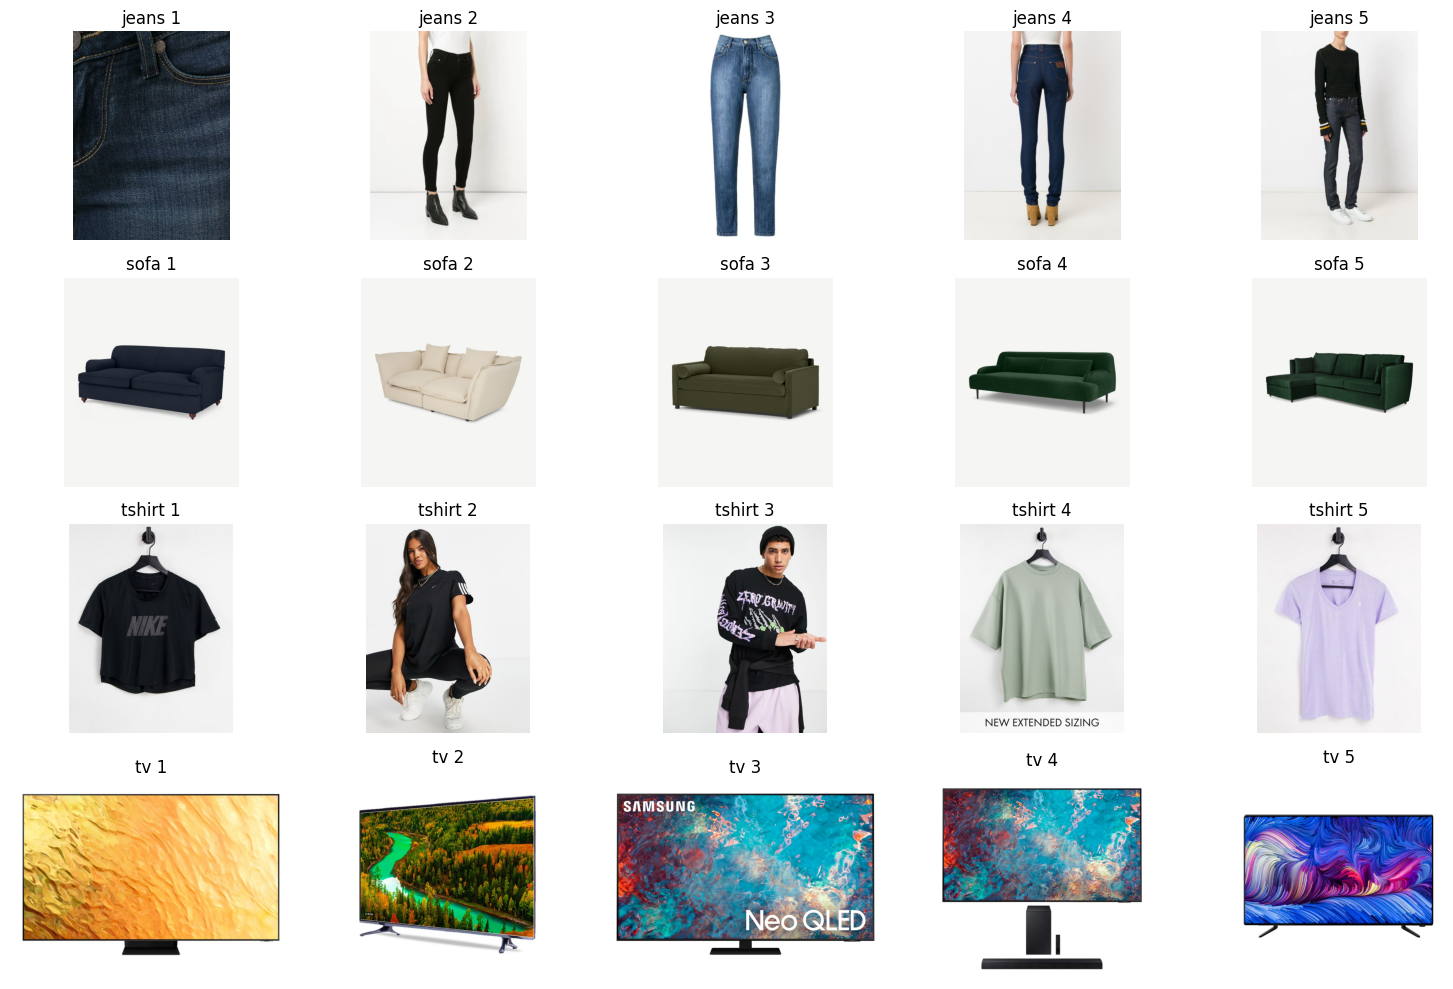

In [ ]:
fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 10))

for i, category in enumerate(categories):
    category_path = os.path.join(path, "ecommerce products", category)

    if os.path.exists(category_path):
        image_files = [f for f in os.listdir(category_path) if f.endswith((".jpg", ".png"))]

        if category == "tv":
            image_files = [f for f in image_files if ''.join(filter(str.isdigit, f.split(".")[0])) not in remove_numbers]

        image_files = image_files[:num_images]

        for j, file_name in enumerate(image_files):
            image_path = os.path.join(category_path, file_name)
            img = Image.open(image_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{category} {j+1}")

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
# ... (otras importaciones y definiciones)
from PIL import Image

# Definir parámetros
target_size = (224, 224)  # Tamaño uniforme de imágenes
batch_size = 32  # Tamaño de lote para entrenamiento
test_size = 0.2  # Proporción de datos de prueba

data = []
labels = []

# Cargar imágenes y etiquetas
for category in categories:
    category_path = os.path.join(path, "ecommerce products", category)

    if os.path.exists(category_path):
        for file_name in os.listdir(category_path):
            if file_name.endswith(".jpg") or file_name.endswith(".png"):
                image_path = os.path.join(category_path, file_name)
                # Convertir a RGB para asegurar que todas tengan 3 canales
                img = Image.open(image_path).convert('RGB').resize(target_size)
                img = np.array(img) / 255.0  # Normalizar valores entre 0 y 1
                data.append(img)
                labels.append(category)

# Convertir a arrays de NumPy
data = np.array(data, dtype=np.float32)
labels = np.array(labels)

# Codificar etiquetas en números
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

# Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=test_size, stratify=labels, random_state=42
)

# Data Augmentation para entrenamiento
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()  # Solo normalización

# Generadores de imágenes
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

print("Preprocesamiento completado. Listo para entrenar la CNN.")


Preprocesamiento completado. Listo para entrenar la CNN.


In [ ]:
len(X_train)

636

In [ ]:
# Calcular el número de imágenes generadas por el Data Augmentation

# Cada imagen original en el conjunto de entrenamiento puede ser transformada varias veces
# La cantidad de imágenes generadas dependerá de la cantidad de imágenes de entrenamiento
num_original_images = len(X_train)

# Suponiendo que cada imagen se transforma en múltiples variaciones en cada época de entrenamiento,
# podemos estimar el número total de imágenes generadas en una época.
num_augmented_images_per_epoch = num_original_images * batch_size

# Mostrar resultados
num_original_images, num_augmented_images_per_epoch


(636, 20352)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Número de clases (modifica según tus categorías)
num_classes = len(categories)  # o asigna directamente el número, por ejemplo, 10

# Definir la arquitectura de la CNN
model = Sequential()

# Primer bloque: Conv -> BatchNorm -> Pool
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Segundo bloque: Conv -> BatchNorm -> Pool
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Tercer bloque: Conv -> BatchNorm -> Pool
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Opcional: Cuarto bloque para extraer características adicionales
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Aplanamiento de las características extraídas
model.add(Flatten())

# Capa densa intermedia con Dropout para reducir el overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Capa de salida: el número de neuronas debe ser igual al número de clases y se utiliza softmax
model.add(Dense(num_classes, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # O 'categorical_crossentropy' si usas one-hot encoding
              metrics=['accuracy'])

# Resumen del modelo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,813,508 (25.99 MB)

 Trainable params: 6,812,548 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Número de épocas para el entrenamiento
epochs = 40

# Ajuste del modelo utilizando el generador de datos para entrenamiento y validación
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 514ms/step - accuracy: 0.5211 - loss: 8.4549 - val_accuracy: 0.2500 - val_loss: 31.7478
Epoch 2/40
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5625 - loss: 12.8021

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5625 - loss: 12.8021 - val_accuracy: 0.2500 - val_loss: 26.8842
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 387ms/step - accuracy: 0.7385 - loss: 5.6255 - val_accuracy: 0.2562 - val_loss: 33.4424
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6875 - loss: 1.5296 - val_accuracy: 0.2562 - val_loss: 36.0595
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 388ms/step - accuracy: 0.7623 - loss: 2.2574 - val_accuracy: 0.2750 - val_loss: 22.6456
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7812 - loss: 0.9966 - val_accuracy: 0.2688 - val_loss: 23.0522
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 336ms/step - accuracy: 0.8246 - loss: 1.4549 - val_accuracy: 0.5188 - val_loss: 20.0521
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9375 - loss: 0.8199 - val_accuracy: 0.5188 - val_loss: 20.0362
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - accuracy: 0.7683 - loss: 0.7029 - val_accuracy: 0.4625 - 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Asegúrate de que el generador del conjunto de prueba no tenga mezcla de datos
# Esto es fundamental para que los índices de las predicciones coincidan con y_test.
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

# Calcular el número de pasos (lotes) necesarios para cubrir el conjunto de prueba
steps = len(test_generator)

# Obtener las predicciones del modelo utilizando el generador de prueba
y_pred_probs = model.predict(test_generator, steps=steps, verbose=1)
# Convertir las probabilidades en etiquetas predichas (se asume clasificación multi-clase)
y_pred = np.argmax(y_pred_probs, axis=1)

# Imprimir la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(cm)

# Imprimir el reporte de clasificación
# Se utilizan los nombres de las clases a partir del LabelEncoder, asumiendo que lo usaste.
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Matriz de Confusión:
[[39  0  0  1]
 [ 0  3  0 37]
 [ 0  0 38  2]
 [ 2  0  0 38]]

Reporte de Clasificación:
              precision    recall  f1-score   support

       jeans       0.95      0.97      0.96        40
        sofa       1.00      0.07      0.14        40
      tshirt       1.00      0.95      0.97        40
          tv       0.49      0.95      0.64        40

    accuracy                           0.74       160
   macro avg       0.86      0.74      0.68       160
weighted avg       0.86      0.74      0.68       160



5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


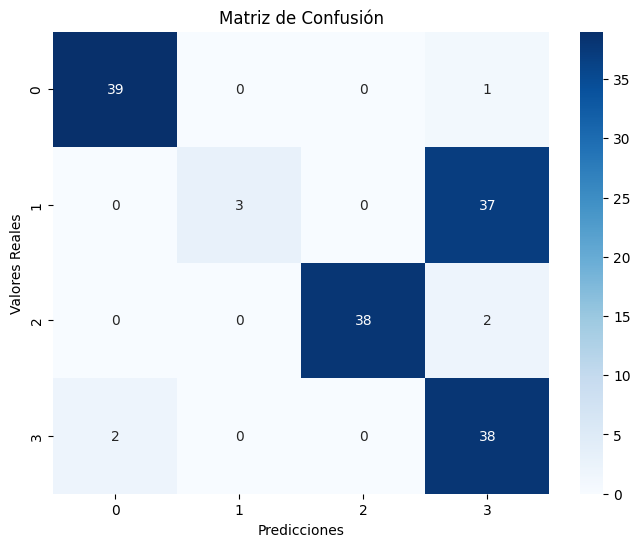

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Simulación de datos de prueba y predicciones
y_pred_probs = model.predict(test_generator, steps=steps, verbose=1)
# Convertir las probabilidades en etiquetas predichas (se asume clasificación multi-clase)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear el gráfico con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

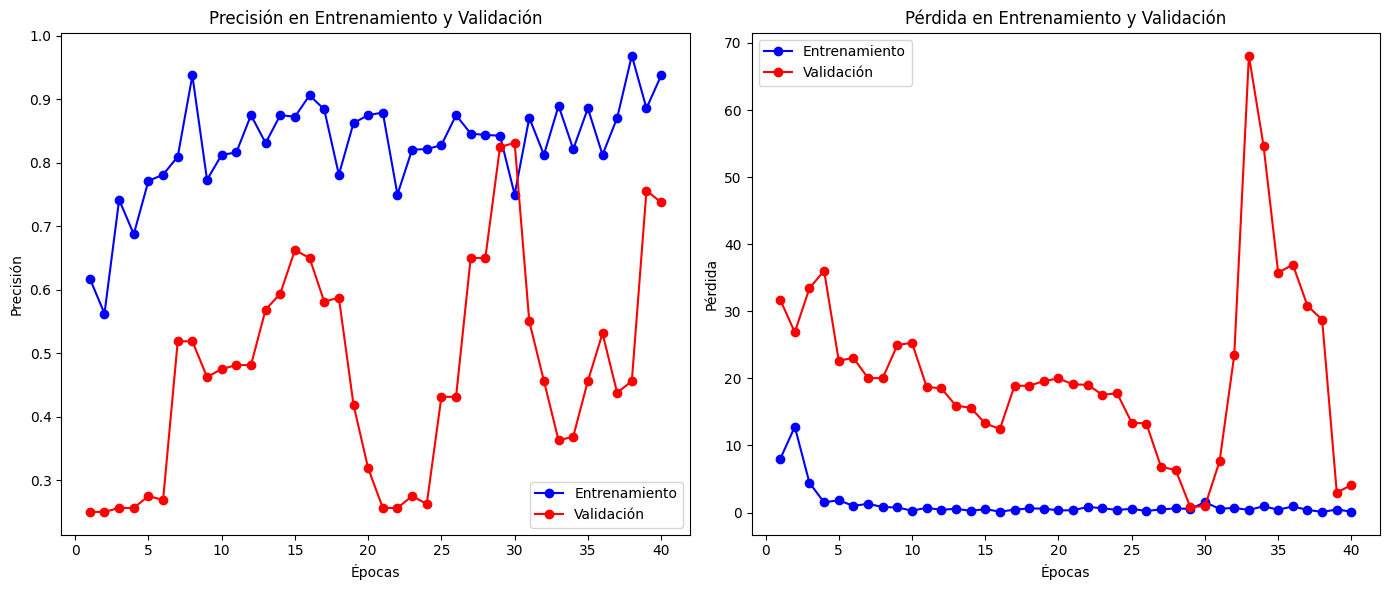

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Número de épocas
epochs = range(1, len(acc) + 1)

# Configurar la figura para dos subgráficos
plt.figure(figsize=(14, 6))

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Entrenamiento')
plt.plot(epochs, val_acc, 'ro-', label='Validación')
plt.title('Precisión en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Supongamos que tienes definidas tus categorías
categories = ['jeans', 'sofa', 'tshirt', 'tv']
num_classes = len(categories)

# Cargar MobileNetV2 preentrenado en ImageNet, sin incluir la capa de clasificación (include_top=False)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base para evitar que se entrenen en este primer paso
base_model.trainable = False

# Agregar nuevas capas para adaptar el modelo a tu problema específico
x = base_model.output
x = GlobalAveragePooling2D()(x)           # Aplanamiento global
x = Dense(128, activation='relu')(x)        # Capa densa intermedia
x = Dropout(0.5)(x)                         # Dropout para reducir el overfitting
predictions = Dense(num_classes, activation='softmax')(x)  # Capa de salida

# Definir el modelo final
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Número de épocas para el entrenamiento
epochs = 20

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 621ms/step - accuracy: 0.6580 - loss: 0.8060 - val_accuracy: 0.9688 - val_loss: 0.0823
Epoch 2/20
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0622

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0622 - val_accuracy: 0.9688 - val_loss: 0.0854
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.9725 - loss: 0.0919 - val_accuracy: 0.9812 - val_loss: 0.0511
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.1288 - val_accuracy: 0.9812 - val_loss: 0.0522
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 322ms/step - accuracy: 0.9837 - loss: 0.0657 - val_accuracy: 0.9812 - val_loss: 0.0485
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0120 - val_accuracy: 0.9812 - val_loss: 0.0445
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - accuracy: 0.9781 - loss: 0.0452 - val_accuracy: 0.9875 - val_loss: 0.0401
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0206 - val_accuracy: 0.9875 - val_loss: 0.0394
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.9920 - loss: 0.0324 - val_accuracy: 0.9875 - val_lo

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


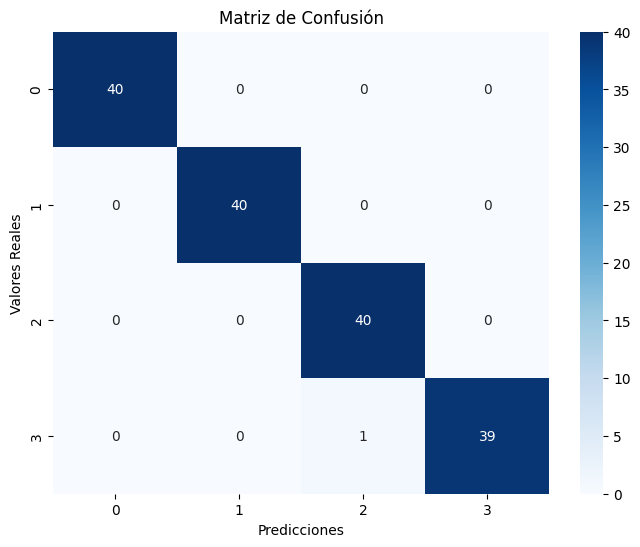

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Simulación de datos de prueba y predicciones
y_pred_probs = model.predict(test_generator, steps=steps, verbose=1)
# Convertir las probabilidades en etiquetas predichas (se asume clasificación multi-clase)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear el gráfico con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

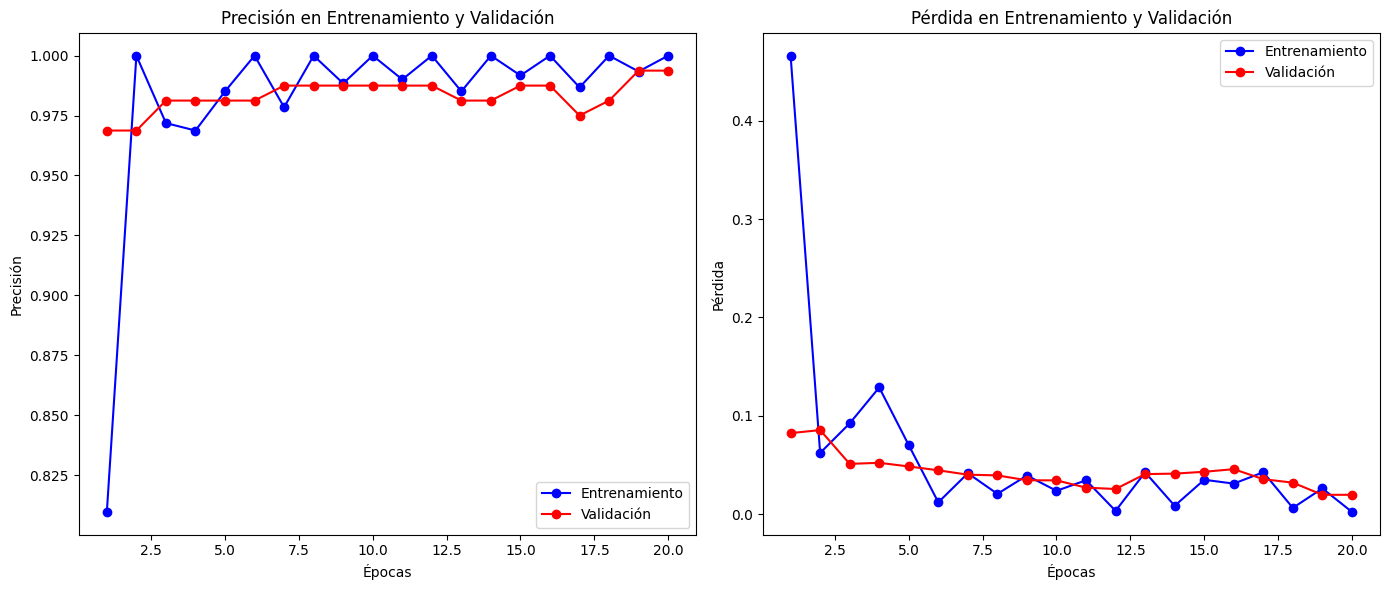

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Número de épocas
epochs = range(1, len(acc) + 1)

# Configurar la figura para dos subgráficos
plt.figure(figsize=(14, 6))

# Gráfico de Precisión (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Entrenamiento')
plt.plot(epochs, val_acc, 'ro-', label='Validación')
plt.title('Precisión en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfico de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
plt.plot(epochs, val_loss, 'ro-', label='Validación')
plt.title('Pérdida en Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))


Reporte de Clasificación:
              precision    recall  f1-score   support

       jeans       1.00      1.00      1.00        40
        sofa       1.00      1.00      1.00        40
      tshirt       0.98      1.00      0.99        40
          tv       1.00      0.97      0.99        40

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160



In [ ]:
model.save("preentrenado.keras")